<h5>Importing libraries</h5>

In [15]:
# data handling
import pandas as pd
import numpy as np
import os 
from PIL import Image

# Machine learning (non deep learning)
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay


# Deep learning
import tensorflow as tf
import keras
from keras import layers
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# misc
import time

<h5>Read in images into numpy arrays and record type of tumor with one hot encoder</h5>

In [16]:
img_reshape_size = (128,128)

data = []
result = []

encoder = OneHotEncoder()
encoder.fit([[0], [1]]) 

# path to tumor files
tumor_image_dir = "dataset/split_data/binary/tumor"
tumor_files = os.listdir(tumor_image_dir)

# path to non tumor files
no_tumor_image_dir = "dataset/split_data/binary/no_tumor"
no_tumor_files = os.listdir(no_tumor_image_dir)

for file in tumor_files:
    temp_file_path = "dataset/split_data/binary/tumor/"+file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    data.append(np.array(img))
    result.append(encoder.transform([[1]]).toarray())
        

for file in no_tumor_files:
    temp_file_path = "dataset/split_data/binary/no_tumor/"+file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    data.append(np.array(img))
    result.append(encoder.transform([[0]]).toarray())

<h5>Reshape data and split between test and train data</h5>

In [17]:
data = np.array(data)
print(data.shape)

result = np.array(result)
result = result.reshape(3000,2)

x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.05, shuffle=True, random_state=0)

(3000, 128, 128)


<h5>Build the CNN model</h5>

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 1), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax',  metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      160       
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)       

<h5>Train the model and record time to train</h5>

In [19]:
start_time = time.time()
history = model.fit(x_train, y_train, epochs = 300, batch_size = 8, verbose = 1,validation_data = (x_test, y_test), callbacks=[callback])
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/300
357/357 [==============================] - 59s 164ms/step - loss: 3.9171 - accuracy: 0.8530 - val_loss: 0.3845 - val_accuracy: 0.9200
Epoch 2/300
357/357 [==============================] - 59s 164ms/step - loss: 0.3733 - accuracy: 0.9182 - val_loss: 0.1875 - val_accuracy: 0.9400
Epoch 3/300
357/357 [==============================] - 58s 162ms/step - loss: 0.1628 - accuracy: 0.9470 - val_loss: 0.1292 - val_accuracy: 0.9533
Epoch 4/300
357/357 [==============================] - 58s 161ms/step - loss: 0.1282 - accuracy: 0.9607 - val_loss: 0.1203 - val_accuracy: 0.9600
Epoch 5/300
357/357 [==============================] - 57s 161ms/step - loss: 0.0861 - accuracy: 0.9719 - val_loss: 0.1586 - val_accuracy: 0.9533
Epoch 6/300
357/357 [==============================] - 58s 161ms/step - loss: 0.0635 - accuracy: 0.9744 - val_loss: 0.1472 - val_accuracy: 0.9667
Epoch 7/300
357/357 [==============================] - 58s 162ms/step - loss: 0.0511 - accuracy: 0.9793 - val_loss: 0.1306 -

<h6>Some basic results recording, just for keeping information to hand</h6>

30.509965896606445 seconds --- 30 epochs , 0.9683 acc , 16x16 Greyscale image <br>
86.94418954849243 seconds --- 30 epochs , 0.9783 acc , 32x32 Greyscale image <br>
169.6840739250183 seconds --- 60 epochs , 0.9667 acc , 32x32 Greyscale image <br>
335.7380225658417 seconds --- 30 epochs , 0.9700 acc , 64x64 Greyscale image <br>


In [20]:
history.history

{'loss': [3.917060613632202,
  0.3732874095439911,
  0.16278763115406036,
  0.12820938229560852,
  0.08612233400344849,
  0.0635099783539772,
  0.05111237242817879,
  0.07946643233299255,
  0.04172676056623459,
  0.033485788851976395,
  0.023588037118315697,
  0.007514500990509987,
  0.010242031887173653,
  0.022113295271992683,
  0.02909870818257332,
  0.019246796146035194,
  0.012406307272613049,
  0.011515042744576931,
  0.014150172472000122,
  0.01702846586704254,
  0.01207013614475727,
  0.004488413687795401,
  0.0025373855605721474],
 'accuracy': [0.8529824614524841,
  0.9182456135749817,
  0.9470175504684448,
  0.9607017636299133,
  0.9719298481941223,
  0.9743859767913818,
  0.9792982339859009,
  0.9771929979324341,
  0.9877192974090576,
  0.9898245334625244,
  0.9908772110939026,
  0.9971929788589478,
  0.9964912533760071,
  0.9947368502616882,
  0.9940350651741028,
  0.9936842322349548,
  0.9964912533760071,
  0.996842086315155,
  0.9957894682884216,
  0.9964912533760071,
  0

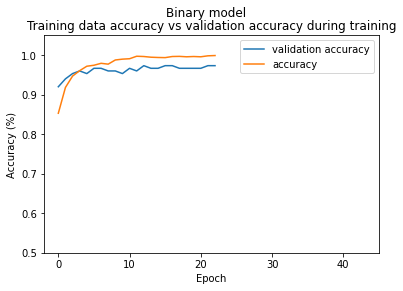

In [21]:
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.plot(history.history['accuracy'], label="accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.suptitle('Binary model')
plt.title('Training data accuracy vs validation accuracy during training')
ax = plt.gca()
ax.set_xlim([-2, 45])
ax.set_ylim([0.5, 1.05])
plt.legend()
plt.show()

<h5>Read in the validation data in the same way we read in the training and testing data</h5>

In [22]:
img_reshape_size = (128,128)

validation_data = []
validation_result = []

# path to non tumor files
no_tumor_image_dir = "test_dataset/test/split_data/binary/no_tumor"
no_tumor_files = os.listdir(no_tumor_image_dir)

# path to tumor files
tumor_image_dir = "test_dataset/test/split_data/binary/tumor"
tumor_files = os.listdir(tumor_image_dir)

test_encoder = OneHotEncoder()
test_encoder.fit([[0], [1]]) 

for file in no_tumor_files:
    temp_file_path = "test_dataset/test/split_data/binary/no_tumor/"+file
    #print("path is " +temp_file_path)
    img = Image.open(temp_file_path).convert('L') # not an RGB image so import as greyscale
    img = img.resize(img_reshape_size)
    img = np.array(img)
    validation_data.append(np.array(img))
    validation_result.append(test_encoder.transform([[0]]).toarray())

for file in tumor_files:
    temp_file_path = "test_dataset/test/split_data/binary/tumor/"+file
    img = Image.open(temp_file_path).convert('L')
    img = img.resize(img_reshape_size)
    img = np.array(img)
    validation_data.append(np.array(img))
    validation_result.append(test_encoder.transform([[1]]).toarray())   

<h5>reshape validation data</h5>

In [23]:
validation_data = np.array(validation_data)
validation_result = np.array(validation_result)
validation_result = validation_result.reshape(200,2)

<h5>Get and print scores</h5>

In [24]:
scores = model.evaluate(validation_data, validation_result, verbose=10)

In [25]:
print("test loss: " + str(scores[0]))
print("test accuracy: " + str(scores[1]))

test loss: 0.09666480123996735
test accuracy: 0.9750000238418579


In [26]:
predictions = model.predict(validation_data)

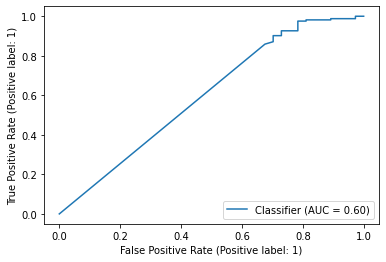

In [27]:
RocCurveDisplay.from_predictions(np.argmax(validation_result, axis=1), np.max(predictions, axis=1)) 

In [28]:
sklearn.metrics.plot_roc_curve(model, validation_data, validation_result) 

c:\users\camer\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


ValueError: Expected 'estimator' to be a binary classifier, but got Sequential

In [ ]:
np.argmax(validation_result, axis=1)

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.argmax(validation_result, axis=1), np.argmax(predictions, axis=1))

In [ ]:
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
np.argmax(validation_result, axis=1)

In [ ]:
np.max(predictions, axis=1)